In [1]:
import os
from typing import List, Tuple

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

%matplotlib inline

import settings
import utils

logger = utils.init_logger(f'final_mixed_plots', './outputs')

logger.info("Jupyter notebook start")

DATA_RESULTS = os.path.join(settings.DATA_PATH, "Results")

logger.info(f"Data results: {DATA_RESULTS}")

Index(['Unnamed: 0', 'id', 'age', 'sex', 'event', 'time'], dtype='object')
(root): Jupyter notebook start


(root): Data results: /Users/jmigual/Documents/Projects/CNNSurv/Data/Results


(matplotlib.backends): backend module://ipykernel.pylab.backend_inline version unknown


In [2]:
from utils import all_results

# all_c_index(DATA_RESULTS + "/Model_scalar")

results = {
    'volume': {
        "mixed": all_results(DATA_RESULTS + "/Model_volume_fix_2", "mixed"),  
        # "train": all_results(DATA_RESULTS + "/Model_volume_fix_2", "train"),
    },
    'scalar': {
        "mixed": all_results(DATA_RESULTS + "/Model_scalar_fix_2", "mixed"),
        # "train": all_results(DATA_RESULTS + "/Model_scalar_fix_2", "train"),
    },
    'scalar_CV': {
        "mixed": all_results(DATA_RESULTS + "/Model_scalar_4CV_2", "mixed"),
        "train": all_results(DATA_RESULTS + "/Model_scalar_4CV_2", "train"),
        "test": all_results(DATA_RESULTS + "/Model_scalar_4CV_2", "test"),
    },
    'volume_CV': {
        "mixed": all_results(DATA_RESULTS + "/Model_volume_4CV_2", "mixed"),
        "train": all_results(DATA_RESULTS + "/Model_volume_4CV_2", "train"),
        "test": all_results(DATA_RESULTS + "/Model_volume_4CV_2", "test"),
    }
}

print("Done")

(utils.results): Searching on /Users/jmigual/Documents/Projects/CNNSurv/Data/Results/Model_volume_fix_2 mixed


(utils.results): Found 509


(utils.results): Finished /Users/jmigual/Documents/Projects/CNNSurv/Data/Results/Model_volume_fix_2 mixed



(utils.results): Searching on /Users/jmigual/Documents/Projects/CNNSurv/Data/Results/Model_scalar_fix_2 mixed


(utils.results): Found 509


(utils.results): Finished /Users/jmigual/Documents/Projects/CNNSurv/Data/Results/Model_scalar_fix_2 mixed



(utils.results): Searching on /Users/jmigual/Documents/Projects/CNNSurv/Data/Results/Model_scalar_4CV_2 mixed


(utils.results): Found 4


(utils.results): Finished /Users/jmigual/Documents/Projects/CNNSurv/Data/Results/Model_scalar_4CV_2 mixed



(utils.results): Searching on /Users/jmigual/Documents/Projects/CNNSurv/Data/Results/Model_scalar_4CV_2 train


(utils.results): Found 4


(utils.results): Finished /Users/jmigual/Documents/Projects/CNNSurv/Data/Results/Model_scalar_4CV_2 train



(utils.results): Searching on /Users/jmigual/Documents/Projects/CNNSurv/Data/Results/Model_scalar_4CV_2 test


(utils.results): Found 4


(utils.results): Finished /Users/jmigual/Documents/Projects/CNNSurv/Data/Results/Model_scalar_4CV_2 test



(utils.results): Searching on /Users/jmigual/Documents/Projects/CNNSurv/Data/Results/Model_volume_4CV_2 mixed


(utils.results): Found 4


(utils.results): Finished /Users/jmigual/Documents/Projects/CNNSurv/Data/Results/Model_volume_4CV_2 mixed



(utils.results): Searching on /Users/jmigual/Documents/Projects/CNNSurv/Data/Results/Model_volume_4CV_2 train


(utils.results): Found 4


(utils.results): Finished /Users/jmigual/Documents/Projects/CNNSurv/Data/Results/Model_volume_4CV_2 train



(utils.results): Searching on /Users/jmigual/Documents/Projects/CNNSurv/Data/Results/Model_volume_4CV_2 test


(utils.results): Found 4


(utils.results): Finished /Users/jmigual/Documents/Projects/CNNSurv/Data/Results/Model_volume_4CV_2 test



Done


scalar
Index(['censored', 'id', 'right', 'total', 'c-index'], dtype='object')
Count: 93980
Mean: 0.7459351531423797
Median: 0.8324324324324325
Std: 0.2559268156768278
c-index cens 0.7462545222387742
c-index no cens 0.5836956521739131


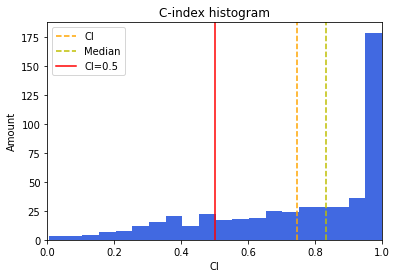

volume
Index(['censored', 'id', 'right', 'total', 'c-index'], dtype='object')
Count: 93980
Mean: 0.6155752852878505
Median: 0.6108108108108108
Std: 0.20885448623243283
c-index cens 0.615684188125133
c-index no cens 0.5602526439482961


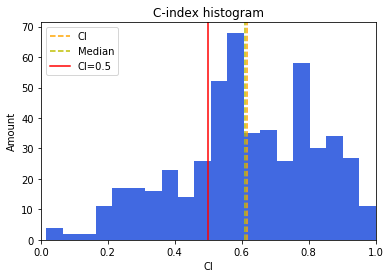

In [22]:
from matplotlib.lines import Line2D


def results_hits(cens_results: pd.DataFrame, uncens_results: pd.DataFrame, name):
    print(f"{name}")
    print(cens_results.columns)
    mean = cens_results['c-index'].mean()
    median = cens_results['c-index'].median()
    std = cens_results['c-index'].std()
    print(f"Count: {cens_results['total'].sum()}")
    print(f"Mean: {mean}")
    print(f"Median: {median}")
    print(f"Std: {std}")
    
    all_c_index = cens_results['right'].sum(axis=0)/cens_results['total'].sum(axis=0)
    
    print(f"c-index cens {all_c_index}")
    
    no_cens_c_index = uncens_results['right'].sum(axis=0)/uncens_results['total'].sum(axis=0)
    
    print(f"c-index no cens {no_cens_c_index}")
    
    n, bins, patches = plt.hist([
                                    cens_results['c-index'], 
                                    # uncens_results['c-index']
                                ],
                                bins=20,
                                label=['All', 'Non censored'],
                                color=[
                                    'royalblue', 
                                    # 'orange'
                                ])
    
    # max_val = max(map(lambda x: max(map(lambda y: y.get_height(), x)), patches))
    
    # n, bins, patches = plt.hist([cens_results['c-index']],
    #                             bins=20,
    #                             label=['All'],
    #                             color=['royalblue'],
    #                             range=(0, 1))
    # max_val = max(map(lambda x: x.get_height(), patches))
    
    plt.axvline(all_c_index, color='orange', linestyle='dashed')
    # plt.text(all_c_index, max_val*.8, 'CI all', rotation=90)
    # plt.text(all_c_index, 150, 'CI all', rotation=90)
    
    plt.axvline(.5, color='r')
    
    # plt.axvline(no_cens_c_index, color='black', linestyle='dashed')
    # plt.text(no_cens_c_index, max_val*.8, 'CI no censored', rotation=90)
    
    # plt.axvline(float(mean), color='g', linestyle='dashed')
    # plt.text(float(mean), max_val*.8, "mean", rotation=-90)

    plt.axvline(float(median), color='y', linestyle='dashed')
    # plt.text(float(median), max_val*.8, "median", rotation=-90)
    
    plt.xlim(0, 1)
    
    plt.xlabel("CI")
    plt.ylabel("Amount")
    
    ax = plt.gca()
    lines = [
        Line2D([0], [0], color='orange', linestyle='dashed'),
        # Line2D([0], [0], color='g', linestyle='dashed'),
        Line2D([0], [0], color='y', linestyle='dashed'),
        Line2D([0], [0], color='r'),
        # Line2D([0], [0], color='royalblue', lw=5),
        # Line2D([0], [0], color='orange', lw=5),
    ]
    ax.legend(lines, [
        "CI", 
        # "Mean", 
        "Median", 
        "CI=0.5", 
        # "All", 
        # "Uncensored"
    ])
    
    # plt.legend(loc='upper left')
    plt.title("C-index histogram")
    
    plt.savefig(f"outputs/c-index_{name}.png", dpi=300)
    plt.show()
    
    
results_hits(*(results['scalar']['mixed'][0]), "scalar")
results_hits(*(results['volume']['mixed'][0]), "volume")

# print("Scalar CV")
# results_hits(*(results['scalar_CV']['mixed'][0]), "scalar_mixed")
# results_hits(*(results['scalar_CV']['train'][0]), "scalar_train")
# results_hits(*(results['scalar_CV']['test'][0]), "scalar_test")
# 
# print("Volume CV")
# results_hits(*(results['volume_CV']['mixed'][0]), "volume_mixed")
# results_hits(*(results['volume_CV']['train'][0]), "volume_train")
# results_hits(*(results['volume_CV']['test'][0]), "volume_test")


In [29]:
def create_latex_table(all_dict):
    # print(r"\textbf{Fold} & \textbf{Train} & \textbf{Test} & \textbf{Mixed} & \textbf{Train} "
    #       r"& \textbf{Test} & \textbf{Mixed} \\")
    
    keys = list(all_dict.keys())
    
    res = ""
    for key in keys:
        res += r" & \textbf{" + f"{key.capitalize()}" + r"}"
    res = r"\textbf{Fold}" + res*2 + r" \\"
    print(res)
    
    length = len(all_dict['train'][0][0])
    for i in range(length):
        temp_total = f"{i}"
        temp_ci = ""
        for key in keys:
            sel_set, _ = all_dict[key][0]
            total = sel_set['total'].iloc[i]
            c_i = sel_set['right'].iloc[i]/total
            temp_total += f" & {total:,}"
            temp_ci += f" & {c_i:.3}"
        temp_ci += r" \\"
        print_str = temp_total + temp_ci
        print_str = print_str.replace(",", "[").replace(".", ",").replace("[", ".")
        print(print_str)
        
    res_total = r"\textbf{Total}"
    res_ci = ""
    for key in keys:
        sel_set, _ = all_dict[key][0]
        total = sel_set['total'].sum()
        c_i = sel_set['right'].sum()/total
        res_total += f" & {total:,}"
        res_ci += f" & {c_i:.3}"
    res_ci = res_ci + r" \\"
    print_str = res_total + res_ci
    print_str = print_str.replace(",", "[").replace(".", ",").replace("[", ".")
    print(res_total + res_ci)
    
    
create_latex_table(results['volume_CV'])
create_latex_table(results['scalar_CV'])
# create_latex_table(results['scalar'])
# create_latex_table(results['volume'])


\textbf{Fold} & \textbf{Mixed} & \textbf{Train} & \textbf{Test} & \textbf{Mixed} & \textbf{Train} & \textbf{Test} \\
0 & 17.664 & 50.720 & 5.708 & 0,622 & 0,614 & 0,653 \\
1 & 17.653 & 51.076 & 5.610 & 0,619 & 0,629 & 0,604 \\
2 & 17.653 & 51.303 & 5.539 & 0,609 & 0,607 & 0,671 \\
3 & 17.653 & 50.794 & 5.692 & 0,613 & 0,644 & 0,563 \\
\textbf{Total} & 70,623 & 203,893 & 22,549 & 0.616 & 0.624 & 0.623 \\
\textbf{Fold} & \textbf{Mixed} & \textbf{Train} & \textbf{Test} & \textbf{Mixed} & \textbf{Train} & \textbf{Test} \\
0 & 17.664 & 50.720 & 5.708 & 0,758 & 0,9 & 0,638 \\
1 & 17.653 & 51.076 & 5.610 & 0,794 & 0,911 & 0,604 \\
2 & 17.653 & 51.303 & 5.539 & 0,738 & 0,898 & 0,679 \\
3 & 17.653 & 50.794 & 5.692 & 0,767 & 0,898 & 0,618 \\
\textbf{Total} & 70,623 & 203,893 & 22,549 & 0.764 & 0.902 & 0.635 \\


Index(['censored', 'id', 'right', 'time', 'total', 'c-index'], dtype='object')


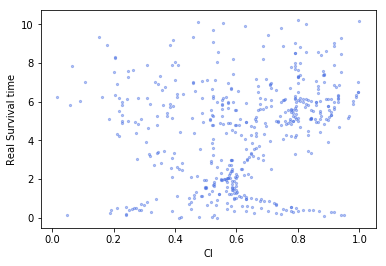

Index(['censored', 'id', 'right', 'time', 'total', 'c-index'], dtype='object')


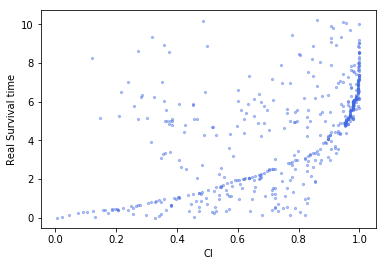

In [7]:
def scatter_results(cens_results: pd.DataFrame, uncens_results: pd.DataFrame, name):
    print(cens_results.columns)
    plt.scatter(cens_results['c-index'], cens_results['time'], label="Censored", color="royalblue", s=5, alpha=.4)
    #plt.scatter(uncens_results['c-index'], uncens_results['total'], label="Non censored", color="orange", s=5, alpha=.4)
    
    # less_pairs = cens_results.loc[cens_results['total'] < 100]
    # print(len(less_pairs))
    # plt.scatter(less_pairs['c-index'], less_pairs['total'], color='red', s=5)
    
    # plt.legend(loc='lower left')
    plt.xlabel("CI")
    plt.ylabel("Real Survival time")
    
    plt.savefig(f"outputs/scatter_{name}.png", dpi=300)
    plt.show()


scatter_results(*(results['volume']['mixed'][0]), 'volume')
scatter_results(*(results['scalar']['mixed'][0]), 'scalar')


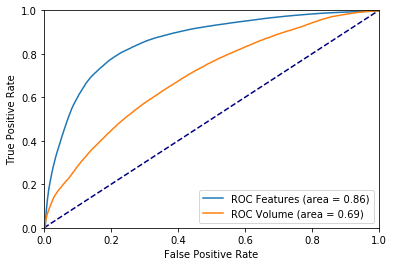

In [55]:

def roc_plot(models: List[Tuple[str, pd.DataFrame]]):
    plt.plot([0, 1], [0, 1], color='navy', linestyle='dashed')
    for name, predictions in models:
        fpr, tpr, _ = roc_curve(predictions['labels'], predictions['probabilities'])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"ROC {name} (area = {roc_auc:.2})")
        
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.legend(loc="lower right")
    
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    
    plt.show()


roc_plot([('Features', results['scalar'][1]), ('Volume', results['volume'][1])])

In [14]:
import math

tasks = 509
workers = 10

length = int(math.ceil(509/workers))
# length = 509 // 41
print(length, length*workers, length*workers - tasks)
limit = tasks - (length - 1)*workers
print("Limit: ", limit)
print("-----------------")

prev_end = 0
for i in range(0, workers):
    task_begin = prev_end
    task_end = task_begin + length - (0 if i < limit else 1)
    task_end = min(task_end, tasks)
        
    prev_end = task_end
        
    # task_end = (i + 1)*length if i + 1 != task_count else tasks - 1
    print(task_begin, task_end - 1, task_end - task_begin)